   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

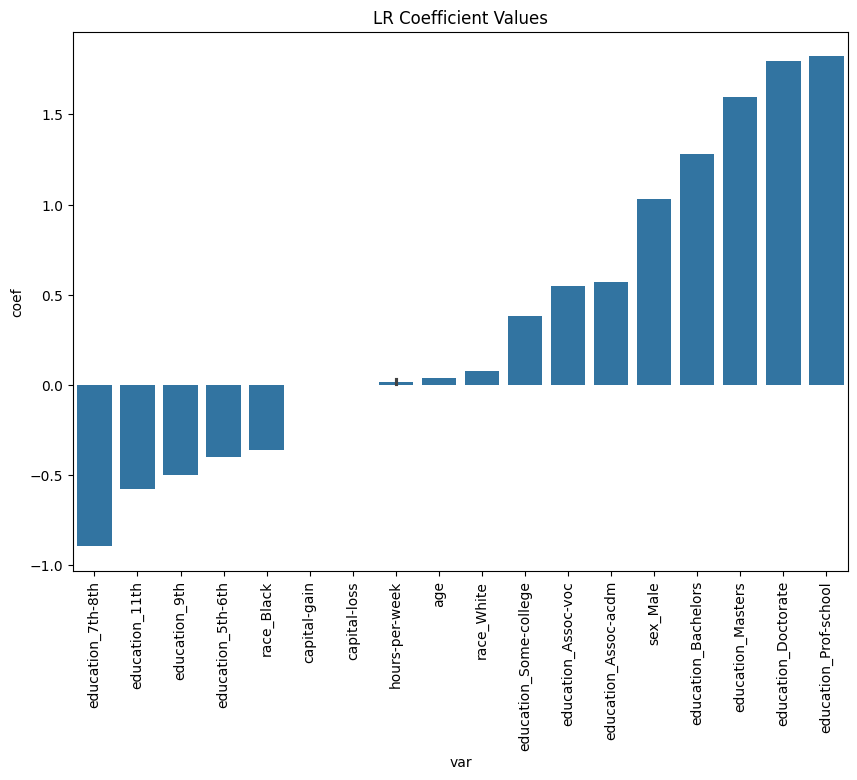

ROC AUC score: 0.845587745338229


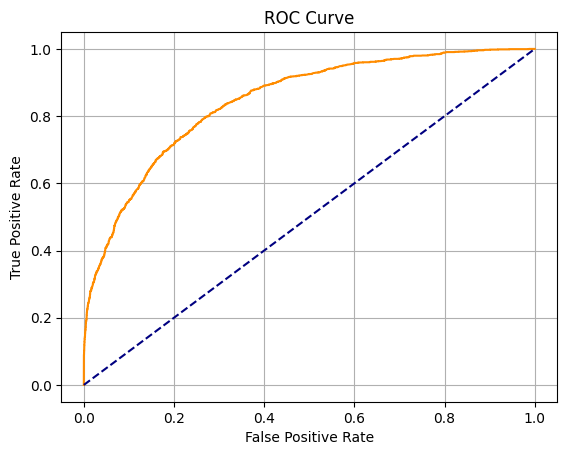

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns


col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

df = pd.read_csv("C:\\Programowanie\\codecademy_projects\\data_sets_codecademy\\census+income\\adult.data", header=None, names=col_names)
#Clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()
print(df.head())

#1. Check Class Imbalance
#Looking at dataset
#print(df.describe())

balance = df['income'].value_counts(normalize=True) * 100


#2. Create feature dataframe X with feature columns and dummy variables for categorical features
feature_cols = ['age','capital-gain', 'capital-loss', 'hours-per-week', 'sex','race', 'hours-per-week', 'education']

X = pd.get_dummies(df[feature_cols], drop_first=True)

#3. Create a heatmap of X data to see feature correlation

corr = X.corr()

#sns.heatmap(corr, annot=False, cmap='coolwarm')
#plt.title('Correlation Matrix')
#plt.show()
#High correlation === race_Whit/race_Black
#4. Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greater than 50k

#y = df['income'].apply([lambda x: 0 if x == '<=50K' else 1])

y = np.where(df.income=='<=50K', 0, 1)

#print(y)
#5a. Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#5b. Fit LR model with sklearn on train set, and predicting on the test set

log_reg = LogisticRegression(C=0.05, penalty='l1', solver='liblinear')

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
#6. Print model parameters (intercept and coefficients)

print('Model Parameters, Intercept:')
print(log_reg.intercept_)

print('Model Parameters, Coeff:')
print(log_reg.coef_)

#7. Evaluate the predictions of the model on the test set. Print the confusion matrix and accuracy score.
confusion_matrix = confusion_matrix(y_test, y_pred)#czm x_test i y_pred????
#aha, jakie wyniki wyjdą na podstawie x_Test i czy będzie się zgadzac z predykcjami ktych dokonalisym
accuracy_score = accuracy_score(y_test, y_pred)

print('Confusion Matrix on test set:')
print(confusion_matrix)

print('Accuracy Score on test set:')
print(accuracy_score)

# 8.Create new DataFrame of the model coefficients and variable names; sort values based on coefficient

coef_df = pd.DataFrame(zip(X_train.columns, log_reg.coef_[0]), columns=['var', 'coef']).sort_values('coef')
coef_df = coef_df[coef_df.coef.abs()>0].sort_values('coef')
print(coef_df)

#9. barplot of the coefficients sorted in ascending order

#9. barplot of the coefficients sorted in ascending order
plt.figure(figsize = (10,7))
sns.barplot(data=coef_df, x='var', y='coef')
plt.xticks(rotation=90);
plt.title('LR Coefficient Values')
plt.show()
plt.close()

#10. Plot the ROC curve and print the AUC value.
y_pred_prob = log_reg.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(f'ROC AUC score: {roc_auc}')

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1], color='navy',linestyle='--')
plt.title('ROC Curve')
plt.grid()
plt.show()


